In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Library Import

# Data Import and Discovery

## Data Loader

In this section, an MNistDataLoader() class is defined with some basic functions to read the binary data from the dataset and load them as lists of data instances.

In [47]:
import numpy as np # linear algebra
import struct
from array import array
from os.path import join
import kagglehub


# Download latest version
dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", dataset_path)


# MNIST Data Loader Class

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    # Function to read the labels and load
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)      

Path to dataset files: C:\Users\mnguyen6\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


## Data Visualization

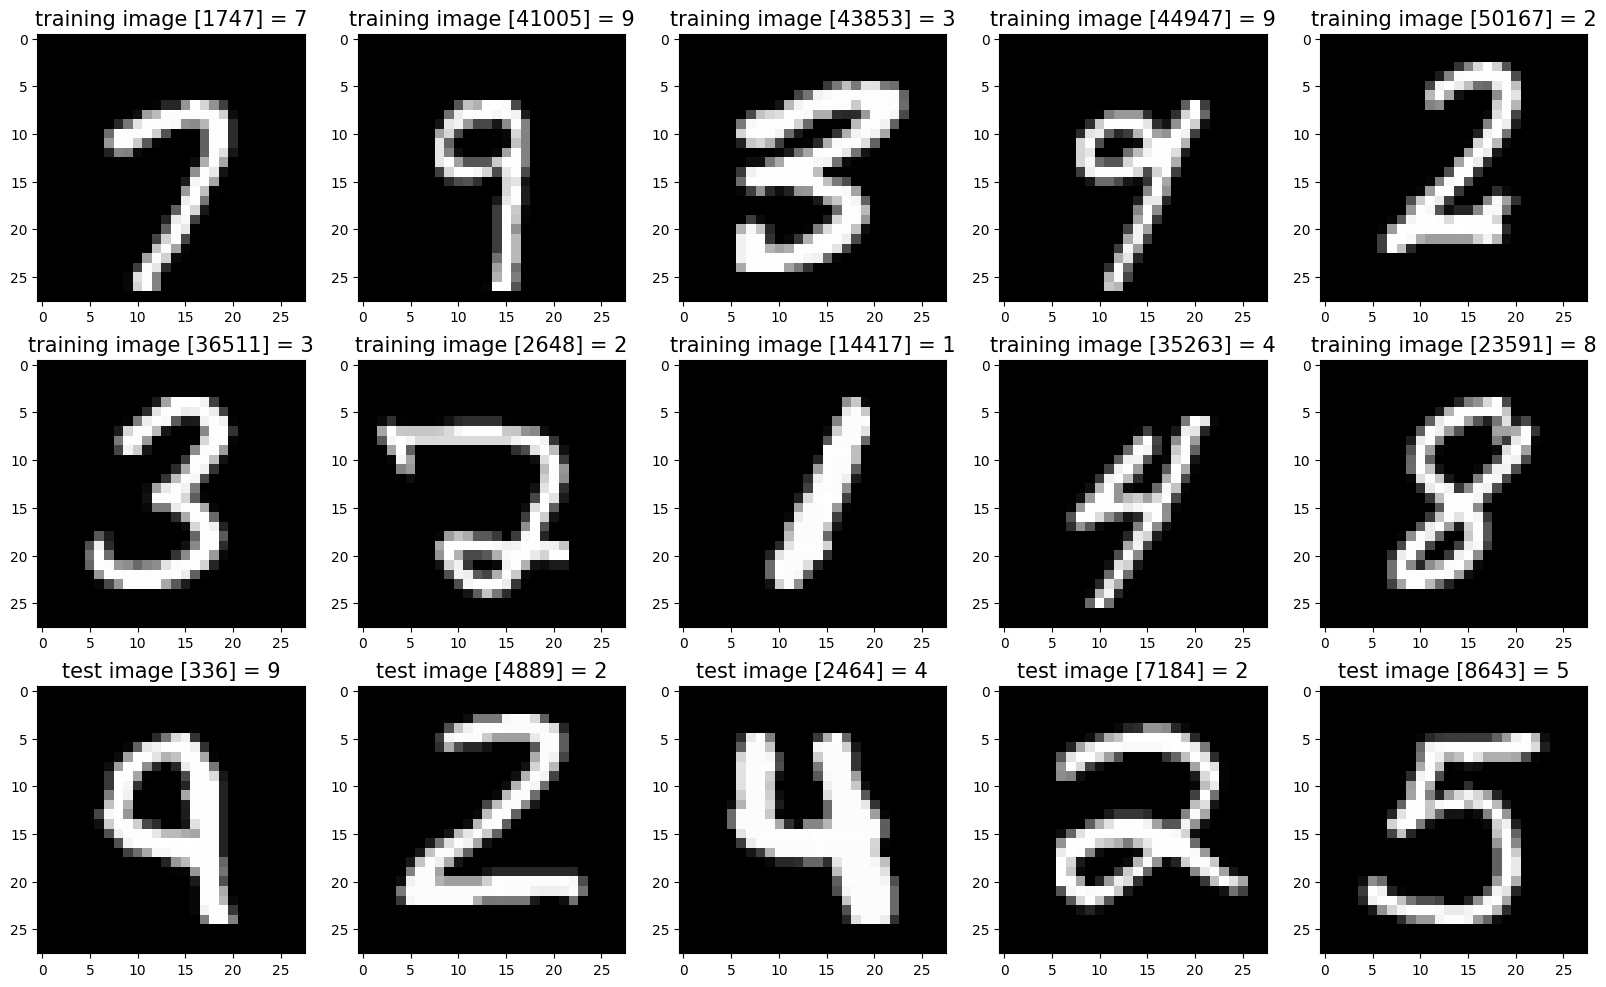

In [48]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

# Set file paths based on added MNIST Datasets
base_path = 'data'
training_images_filepath = join(base_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(base_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(base_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(base_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols)
    plt.figure(figsize=(cols*4,rows*4))
    
    for index, x in enumerate(zip(images, title_texts)):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index+1)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        


# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_trainval, y_trainval), (x_test, y_test) = mnist_dataloader.load_data()


# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_trainval[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_trainval[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [53]:
x_trainval_dim = x_trainval.shape
y_trainval_dim = y_trainval.shape

x_test_dim = x_test.shape
y_test_dim = y_test.shape

print(f"There are {x_trainval_dim[0]} samples in the training dataset, each of size {x_trainval_dim[1],x_trainval_dim[2]} \n"
      f"There are {x_test_dim[0]} samples in the testing dataset ")

print(f"The training label set has dimension of {y_trainval_dim}")

There are 60000 samples in the training dataset, each of size (28, 28) 
There are 10000 samples in the testing dataset 
The training label set has dimension of (60000,)


In [93]:
NUM_CLASS = len(np.unique(y_trainval))

## Train-Validation Data Split

In [55]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_trainval,
                                                  y_trainval,
                                                  test_size=0.2,
                                                  random_state=12)

x_train_dim = np.shape(x_train)
y_train_dim = np.shape(y_train)

x_val_dim = np.shape(x_val)
y_val_dim = np.shape(y_val)

print("After the train-validation data split")

print(f"There are {x_train_dim[0]} samples in the training dataset, each of size {x_train_dim[1:]}. \n"
      f"There are {x_val_dim[0]} samples in the validation dataset.\n"
      f"There are {x_test_dim[0]} samples in the testing dataset.")

print(f"The training label set has dimension of {y_train_dim}")

# The input shape to the NN is the number of pixels in an MNIST image (28x28=784 input)
INPUT_SHAPE = x_train_dim[1:]

After the train-validation data split
There are 48000 samples in the training dataset, each of size (28, 28). 
There are 12000 samples in the validation dataset.
There are 10000 samples in the testing dataset.
The training label set has dimension of (48000,)


In [56]:
INPUT_SHAPE

(28, 28)

## Data Generator

I found that when training or evaluating a model on a GPU with limited RAM (such as 8GB RAM cards like the T1000 or RTX4060), the code often fails since TensorFlow tries to load the full arrays into the GPU memory (even when loading in batches). This code block is an attempt to solve this problem by using a generator to generate data from the training sets to the model in batches. These generators are used directly in model training and testing

In [59]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


BATCH_SIZE = 32

# These generator objects will generate BATCH_SIZE samples at a time from the specified nparray
train_gen = DataGenerator(x_train,y_train,BATCH_SIZE)
val_gen = DataGenerator(x_val,y_val,BATCH_SIZE)
test_gen = DataGenerator(x_test,y_test,BATCH_SIZE)

# Deep Fully-Connected ANN

## ANN Model Construction Function

In [ ]:
import tensorflow as tf                                 # General machine learning functionalities                    
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

def build_ann_model(layer_widths, 
                    input_shape, 
                    activation='relu', 
                    loss='sparse_categorical_crossentropy', 
                    metrics='accuracy', 
                    learning_rate=0.001):
    """
    Creates a Keras Sequential model based on the specified architecture.

    Args:
        layer_widths (list): A list where each element is the number of nodes in a layer.
        input_shape (tuple): Shape of the input data (e.g., (num_features,)).
        activation (str): Activation function to use in the hidden layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): A compiled Keras Sequential model.
    """
    model = keras.Sequential()

    # Add additional hidden layers based on layer_widths
    model.add(layers.Flatten(input_shape=input_shape))
    for i,width in enumerate(layer_widths):
        model.add(layers.Dense(width, activation=activation))
        model.add(layers.BatchNormalization())

    # Add the output layer with width = number of class and softmax activation
    model.add(layers.Dense(NUM_CLASS, activation='softmax', name = "Output_layer"))

    # Compile the model with the provided or default learning rate, loss functions, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss=loss, 
                  metrics=metrics)
    
    return model

In [36]:
INPUT_SHAPE+(1,)

(28, 28, 1)

In [ ]:
LAYER_WIDTHS = [64,32]
LAYER_DEPTH = len(LAYER_WIDTHS)
LEARNING_RATE = 0.0001
EPOCH = 50
ACTIVATION = 'relu'
LOSS = 'sparse_categorical_crossentropy'
METRICS = 'accuracy'

tf.keras.backend.clear_session()
model = build_ann_model(layer_widths=LAYER_WIDTHS,
                        input_shape=INPUT_SHAPE+(1,),
                        activation=ACTIVATION,
                        loss=LOSS,
                        metrics=METRICS,
                        learning_rate=LEARNING_RATE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 Output_layer (Dense)        (None, 10)                3

## Model Experimentation Training

In [126]:
from time import time

train_start = time()
history = model.fit(train_gen,
                    batch_size=BATCH_SIZE,
                    validation_data=val_gen,
                    epochs = EPOCH)
train_end = time()

TRAIN_TIME = train_end - train_start

Epoch 1/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.2082 - val_accuracy: 0.9624
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.1935 - val_accuracy: 0.9661
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 6.0166e-04 - accuracy: 1.0000 - val_loss: 0.1927 - val_accuracy: 0.9662
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 4.1806e-04 - accuracy: 1.0000 - val_loss: 0.1957 - val_accuracy: 0.9658
Epoch 5/50
1500/1500 [==============================] - 4s 3ms/step - loss: 3.5412e-04 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 0.9662
Epoch 6/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.2075 - val_accuracy: 0.9639
Epoch 7/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.2084 - v

## Model directory
This section create the directory that corresponds to the time of the current run and store the training parameters, training performance, evaluation, and testing plots

In [119]:
import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run

# Generate a timestamped directory for the training run
timestamp = datetime.now().strftime("%y%m%d_%H%M%S")
BASE_DIR = os.getcwd()
OUTPUT_DIR = os.path.join(BASE_DIR,f"ann_model_results/{timestamp}_{LAYER_DEPTH}_{LEARNING_RATE}_{EPOCH}")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [128]:
from contextlib import redirect_stdout

# Save the model in H5DF format
MODEL_PATH = os.path.join(OUTPUT_DIR,"model.h5")
model.save(MODEL_PATH)
print(f"Model saved as {MODEL_PATH}")

# Save the model structure
model_path = os.path.join(OUTPUT_DIR, "model_summary.json")
with open(model_path, 'w') as f:
    with redirect_stdout(f):
        model.summary()

# Save the training parameters
training_params = {
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCH,
    "structure": str(LAYER_WIDTHS),
    "loss": LOSS,
    "metrics": METRICS
}

# Store the final training results
training_results = {}
for i in history.history.keys():
    training_results[i] = history.history[i][-1]
training_results['train_time'] = TRAIN_TIME
# Save the training parameters and training results in the directory
params_path = os.path.join(OUTPUT_DIR, "params_results.json")
with open(params_path, "w") as f:
    json.dump({"parameters": training_params, "results": training_results}, f, indent=4)
print(f"Training parameters and results saved at {params_path}")

Model saved as c:\mnguyen\programming-project\mnist\ann_model_results/241129_122303_2_0.0001_50\model.h5
Training parameters and results saved at c:\mnguyen\programming-project\mnist\ann_model_results/241129_122303_2_0.0001_50\params_results.json


Here I defined a helper function that plots the training history and stores in the directory defined above

In [121]:
def plot_performance(history, learning_rate=None, batch_size=None, save_dir=None):
    # Determine whether history is keras history or a dictionary to appropriately extract the history data
    if isinstance(history, keras.callbacks.History):
        history_data = history.history        # Extract the history dictionary
    else:
        history_data = history                # Assume it's already a dictionary

    metric_list = list(history_data.keys())     # Extract the list of history keys
    half_length = len(metric_list) // 2         # The index where the validation metrics start

    metric2txt_dict = {'accuracy': 'Accuracy',
                       'loss': 'Sparse Caregorical Crossentropy Loss'}

    plt.figure(figsize=(half_length * 5,5))

    for index, metric in enumerate(metric_list[:half_length]):
        metric_train = metric
        metric_val = metric_list[index+half_length]

        plt.subplot(1,half_length,index+1)
        ylim_acc = [0, max(max(history_data[metric_train]),max(history_data[metric_val]))]
        plt.plot(history_data[metric_train], label = metric_train)
        plt.plot(history_data[metric_val], label = metric_val)
        plt.ylim(ylim_acc)
        # plt.ylabel(metric_train)
        plt.xlabel('Epoch')
        plt.legend(loc='best')
        if learning_rate and batch_size:
            plt.title(f'{metric2txt_dict[metric_train]} \n lr = {learning_rate}, batch size = {batch_size}')
        else: plt.title(f'{metric2txt_dict[metric_train]}')

        plt.grid(which='major', color='black', linestyle='--', linewidth=0.5)

        # Enable the minor grid
        plt.minorticks_on()  # Turn on the minor ticks
        plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

    # Save the plots if a directory is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        plot_path = os.path.join(save_dir, "performance_plot.png")
        plt.savefig(plot_path)
        print(f"Performance plot saved at {plot_path}")

Performance plot saved at c:\mnguyen\programming-project\mnist\ann_model_results/241129_122303_2_0.0001_50\performance_plot.png


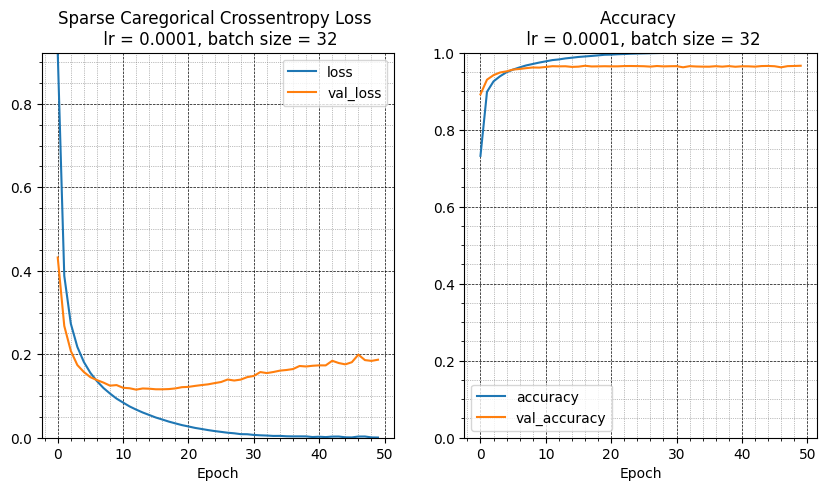

In [122]:
plot_performance(history,learning_rate=LEARNING_RATE,batch_size=BATCH_SIZE,save_dir=OUTPUT_DIR)

## Model Prediction and Evaluation

### Loaded a trained model

In [ ]:
TRAINED_DIRECTORY = os.path.join(BASE_DIR,'241129_122303_2_0.0001_50')

## Result Visualization

In [ ]:
# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_trainval[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_trainval[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Convolutional Neural Networks

## CNN Model Construction Function